In [1]:
from utils.general_utils import *
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from utils.plot_utils import *
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

In [2]:
print("First, we explore the given data, which of course consists of character basic info, stats and super-powers.")
df = pd.read_csv('data/marvel_demo_stats_powers.csv').set_index("Name").drop(['ID', 'Unnamed: 0'], axis=1)
df.head()

First, we explore the given data, which of course consists of character basic info, stats and super-powers.


,Alignment_x,Gender,EyeColor,Race,HairColor,Publisher,SkinColor,Height,Weight,Intelligence,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,good,Male,yellow,Human,No Hair,Marvel Comics,-,203.0,441,38.0,...,False,False,False,False,False,False,False,False,False,False
Abomination,bad,Male,green,Human,No Hair,Marvel Comics,-,203.0,441,63.0,...,False,False,False,False,False,False,False,False,False,False
Abraxas,bad,Male,blue,Cosmic Entity,Black,Marvel Comics,-,-99.0,-99,88.0,...,False,False,False,False,False,False,False,False,False,False
Absorbing Man,bad,Male,blue,Human,No Hair,Marvel Comics,-,193.0,122,NaN,...,False,False,False,False,False,False,False,False,False,False
Agent 13,good,Female,blue,Unknown Race,Blond,Marvel Comics,-,173.0,61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print("We can easily see that our data consists of 3 main types of features: \n "
      "1. Integers (the character's stats). \n"
      " 2. Booleans (The superpowers drilldown). \n"
      " 3. MultiCategorical features, which dictates the basic characteristics of each instance. \n"
      "Now, lets clean all of the unnecessary columns:")
df = df.drop(['Publisher', 'SkinColor'], axis=1)
df.head()

We can easily see that our data consists of 3 main types of features: 
 1. Integers (the character's stats). 
 2. Booleans (The superpowers drilldown). 
 3. MultiCategorical features, which dictates the basic characteristics of each instance. 
Now, lets clean all of the unnecessary columns:


,Alignment_x,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,good,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,...,False,False,False,False,False,False,False,False,False,False
Abomination,bad,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,...,False,False,False,False,False,False,False,False,False,False
Abraxas,bad,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,...,False,False,False,False,False,False,False,False,False,False
Absorbing Man,bad,Male,blue,Human,No Hair,193.0,122,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
Agent 13,good,Female,blue,Unknown Race,Blond,173.0,61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("I removed the publisher feature since all of the data is from the same comicbook publisher (Marvel). \n"
      "I removed SkinColor because this feature had way too much missing data to use here.")
df = df.replace('-', 'no_value')
df['HairColor'].value_counts()

I removed the publisher feature since all of the data is from the same comicbook publisher (Marvel). 
I removed SkinColor because this feature had way too much missing data to use here.


No Hair           94
Black             85
Blond             70
Brown             65
Red               25
White             16
Green              6
Grey               4
Purple             3
Blue               3
Silver             2
Orange             2
black              2
Indigo             1
Orange / White     1
Pink               1
Magenta            1
Gold               1
Name: HairColor, dtype: int64

In [5]:
print("We see that we have many sparse possible values in the HairColor category, \n"
      "A possible solution to avoid that is to create a new value called 'other' and put \n"
      "these values under that umbrella (exept 'black' who should be the same as 'Black').")
haircolors_5_or_less = df['HairColor'].value_counts()
haircolors_5_or_less = haircolors_5_or_less.loc[haircolors_5_or_less < 5].index.tolist()
df['HairColor'] = df['HairColor'].apply(lambda x: "Black" if x == 'black' else 'Other' if x in haircolors_5_or_less else x)
df['HairColor'].value_counts()

We see that we have many sparse possible values in the HairColor category, 
A possible solution to avoid that is to create a new value called 'other' and put 
these values under that umbrella (exept 'black' who should be the same as 'Black').


No Hair    94
Black      87
Blond      70
Brown      65
Red        25
Other      19
White      16
Green       6
Name: HairColor, dtype: int64

In [6]:
print("Lets do the same with EyeColor:")
df['EyeColor'].value_counts()

Lets do the same with EyeColor:


blue                       124
brown                       87
no_value                    47
green                       40
red                         31
white                       13
black                       11
yellow                      10
grey                         4
yellow (without irises)      2
hazel                        2
gold                         2
purple                       2
silver                       1
amber                        1
blue / white                 1
violet                       1
green / blue                 1
yellow / blue                1
white / red                  1
Name: EyeColor, dtype: int64

In [7]:
df['EyeColor'] = df['EyeColor'].apply(lambda x: 'green' if 'green' in x else 'blue' if 'blue' in x else 'yellow' if 'yellow' in x else 'white' if 'white' in x else x)
print("I've consolidated some of the EyeColor values (such as green + green/blue). \n"
      "And now for the rest of the sparse values we can do exactly the same as we did with HairColor.")
eyecolors_5_or_less = df['EyeColor'].value_counts()
eyecolors_5_or_less = eyecolors_5_or_less.loc[eyecolors_5_or_less < 5].index.tolist()
eyecolors_5_or_less.append('no_value')
df['EyeColor'] = df['EyeColor'].apply(lambda x: 'Other' if x in eyecolors_5_or_less else x)
df['EyeColor'].value_counts()

I've consolidated some of the EyeColor values (such as green + green/blue). 
And now for the rest of the sparse values we can do exactly the same as we did with HairColor.


blue      126
brown      87
Other      60
green      41
red        31
white      14
yellow     12
black      11
Name: EyeColor, dtype: int64

In [8]:
print("Lets do this one last time for the 'Race' column.")
race_3_or_less = df['Race'].value_counts()
race_3_or_less = race_3_or_less.loc[race_3_or_less < 3].index.tolist()
race_3_or_less.append('Unknown Race')
df['Race'] = df['Race'].apply(lambda x: 'Other' if x in race_3_or_less else x)
df['Race'].value_counts()

Lets do this one last time for the 'Race' column.


Other            165
Human            107
Mutant            58
Symbiote           9
Alien              7
Radiation          7
Asgardian          6
Cosmic Entity      6
Cyborg             5
Demon              4
Inhuman            4
God / Eternal      4
Name: Race, dtype: int64

In [9]:
print("Now that we have our data clean, we can finally dictate the class out of the alignment column (is good or evil). \n"
      "I've decided to label those who have no alignment value, or have a 'neutral' value, the same as bad value.")

df['class'] = df['Alignment_x'].apply(lambda x: True if x in ['bad', 'neutral', '-'] else False)
df = df.drop('Alignment_x', axis=1)
df.head()

Now that we have our data clean, we can finally dictate the class out of the alignment column (is good or evil). 
I've decided to label those who have no alignment value, or have a 'neutral' value, the same as bad value.


,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,False,False,False,False,False,False,False
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,False,False,False,False,False,False,False,True
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,False,False,False,False,False,False,False,True
Absorbing Man,Male,blue,Human,No Hair,193.0,122,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
Agent 13,Female,blue,Other,Blond,173.0,61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [10]:
print("From the context of the material we're working with, I can suggest that a big chunk of the good superheros tend to be human, mutant, or usually with blue eyes. \n"
      "Because of that, I've decided to extract this information as unique boolean columns.")

df['is_human'] = df['Race'].apply(lambda x: True if 'Human' in x else False)
df['is_mutant'] = df['Race'].apply(lambda x: True if 'Mutant' in x else False)
df['has_blue_eyes'] = df['EyeColor'].apply(lambda x: True if x == 'blue' else False)
df.head()


From the context of the material we're working with, I can suggest that a big chunk of the good superheros tend to be human, mutant, or usually with blue eyes. 
Because of that, I've decided to extract this information as unique boolean columns.


,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class,is_human,is_mutant,has_blue_eyes
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,False,False,False,False,True,False,False
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,False,False,False,False,True,True,False,False
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,False,False,False,False,True,False,False,True
Absorbing Man,Male,blue,Human,No Hair,193.0,122,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,True,True,False,True
Agent 13,Female,blue,Other,Blond,173.0,61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True


In [11]:
print("For next references in the code, lets extract (and separate by type) all of the columns")
cols = list(df.columns)
cat_cols = ['Gender', 'EyeColor', 'Race', 'HairColor']
int_cols = ['Height', 'Weight', 'Intelligence', 'Strength', 'Speed', 'Durability', 'Power', 'Combat', 'Total']
bool_cols = [x for x in cols if (x not in cat_cols and x not in int_cols)]
print("Also, lets quickly fill/fix the empty values in each column.")
df[cat_cols] = df[cat_cols].fillna(value='no_value')
df[int_cols] = df[int_cols].fillna(value=0)
df[bool_cols] = df[bool_cols].fillna(value=False)
df.head()

For next references in the code, lets extract (and separate by type) all of the columns
Also, lets quickly fill/fix the empty values in each column.


,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class,is_human,is_mutant,has_blue_eyes
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,False,False,False,False,True,False,False
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,False,False,False,False,True,True,False,False
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,False,False,False,False,True,False,False,True
Absorbing Man,Male,blue,Human,No Hair,193.0,122,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,True,False,True
Agent 13,Female,blue,Other,Blond,173.0,61,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


In [12]:
print("The last feature we'll add before injecting the data into a categories-considering model, is the amount of different superpowers for each character.")
superpowers_cols = bool_cols
for col in ['is_human', 'is_mutant', 'has_blue_eyes']:
    superpowers_cols.remove(col)

df['amount_of_superpowers'] = df[bool_cols].astype(int).sum(axis=1)
df.head()


The last feature we'll add before injecting the data into a categories-considering model, is the amount of different superpowers for each character.


,Gender,EyeColor,Race,HairColor,Height,Weight,Intelligence,Strength,Speed,Durability,...,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient,class,is_human,is_mutant,has_blue_eyes,amount_of_superpowers
Name,,,,,,,,,,,,,,,,,,,,,
A-Bomb,Male,yellow,Human,No Hair,203.0,441,38.0,100.0,17.0,80.0,...,False,False,False,False,False,False,True,False,False,7
Abomination,Male,green,Human,No Hair,203.0,441,63.0,80.0,53.0,90.0,...,False,False,False,False,False,True,True,False,False,9
Abraxas,Male,blue,Cosmic Entity,Black,-99.0,-99,88.0,100.0,83.0,99.0,...,False,False,False,False,False,True,False,False,True,15
Absorbing Man,Male,blue,Human,No Hair,193.0,122,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,True,False,True,12
Agent 13,Female,blue,Other,Blond,173.0,61,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,0


In [13]:
print("cast int cols to int type.")
for col in int_cols:
    df[col] = df[col].astype(int)


cast int cols to int type.


In [14]:
print("Our data is ready for the model, we can now seperate it to X and Y.")
df = df.reset_index()
X, y = df.copy().drop('class', axis=1), df.copy()['class']

Our data is ready for the model, we can now seperate it to X and Y.


In [15]:
# Model init
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), class_weights=[0.33, 0.67], random_state=5,
                         bootstrap_type='Bayesian', rsm=0.1, verbose=0)
print("Notice the following: \n"
      " 1. we're using a simple homemade function to extract the categorical features, but we could've used the list we prepared earlier. \n"
      " 2. The class weights are in inverse proportion to the class values, as it should. \n"
      " 3. I've chosen the other hyperparameters after testing several for this model.")
evaluation = Evaluation()

Notice the following: 
 1. we're using a simple homemade function to extract the categorical features, but we could've used the list we prepared earlier. 
 2. The class weights are in inverse proportion to the class values, as it should. 
 3. I've chosen the other hyperparameters after testing several for this model.


Lets use the following homemade method to fit and also use stratified k-fold to see the performance:


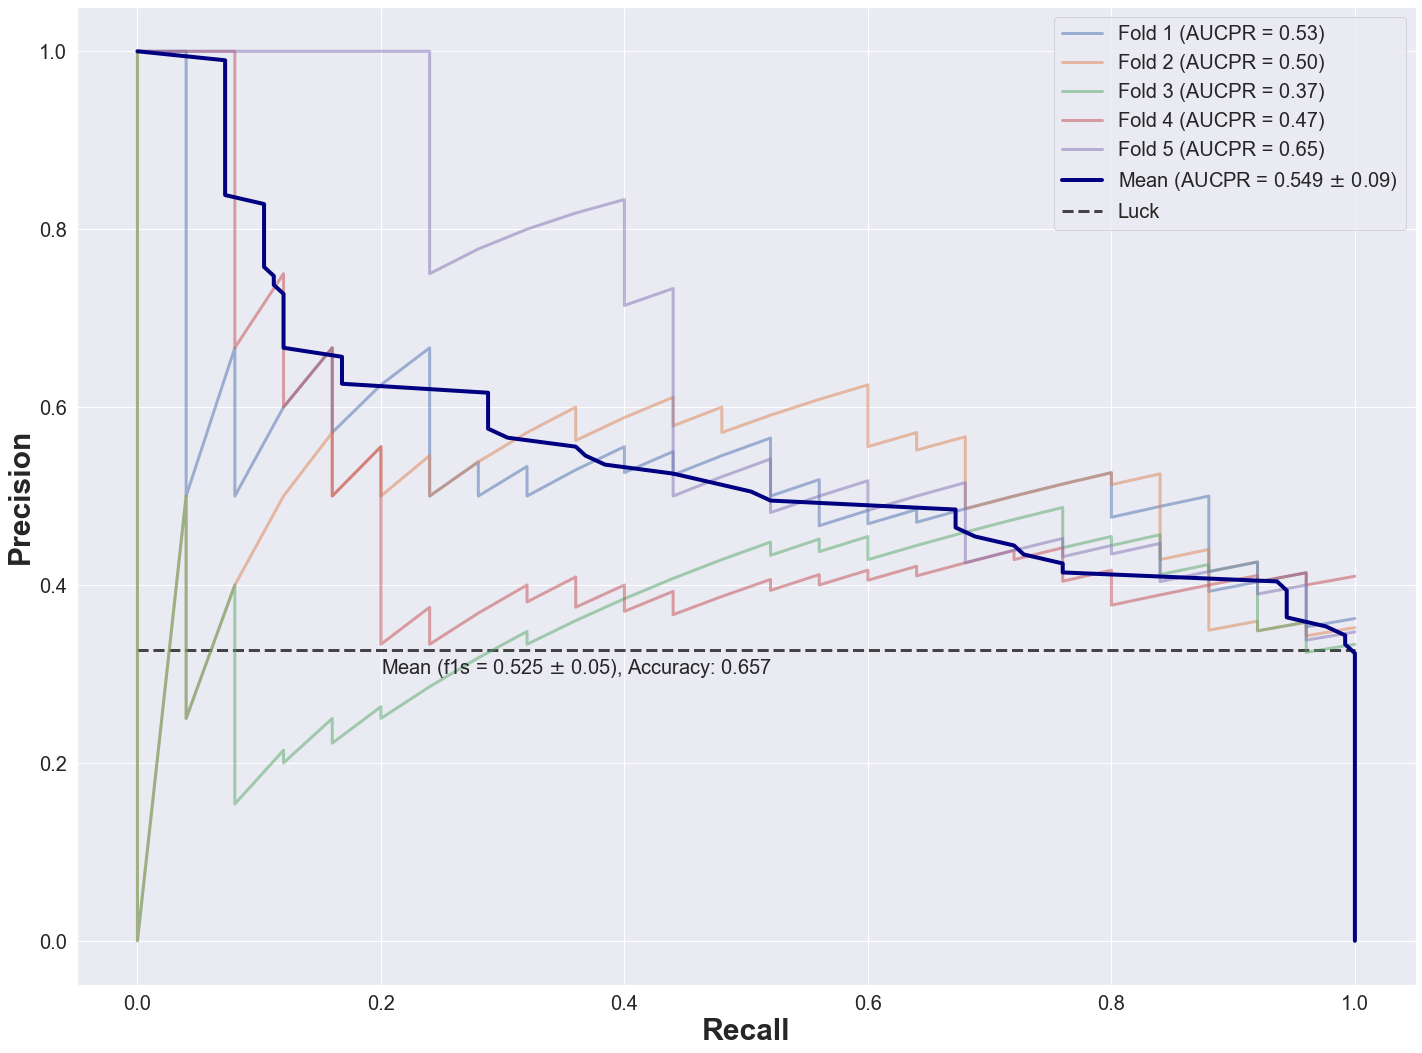

In [16]:
print("Lets use the following homemade method to fit and also use stratified k-fold to see the performance:")
feature_importance = evaluation.plot_cv_precision_recall(cbc, n_folds=5, n_repeats=1, X=X, y=y, random_state=0)

Interesting results, this is a definite improvement over a 'lucky' guess. 
Lets check the feature importance as well:


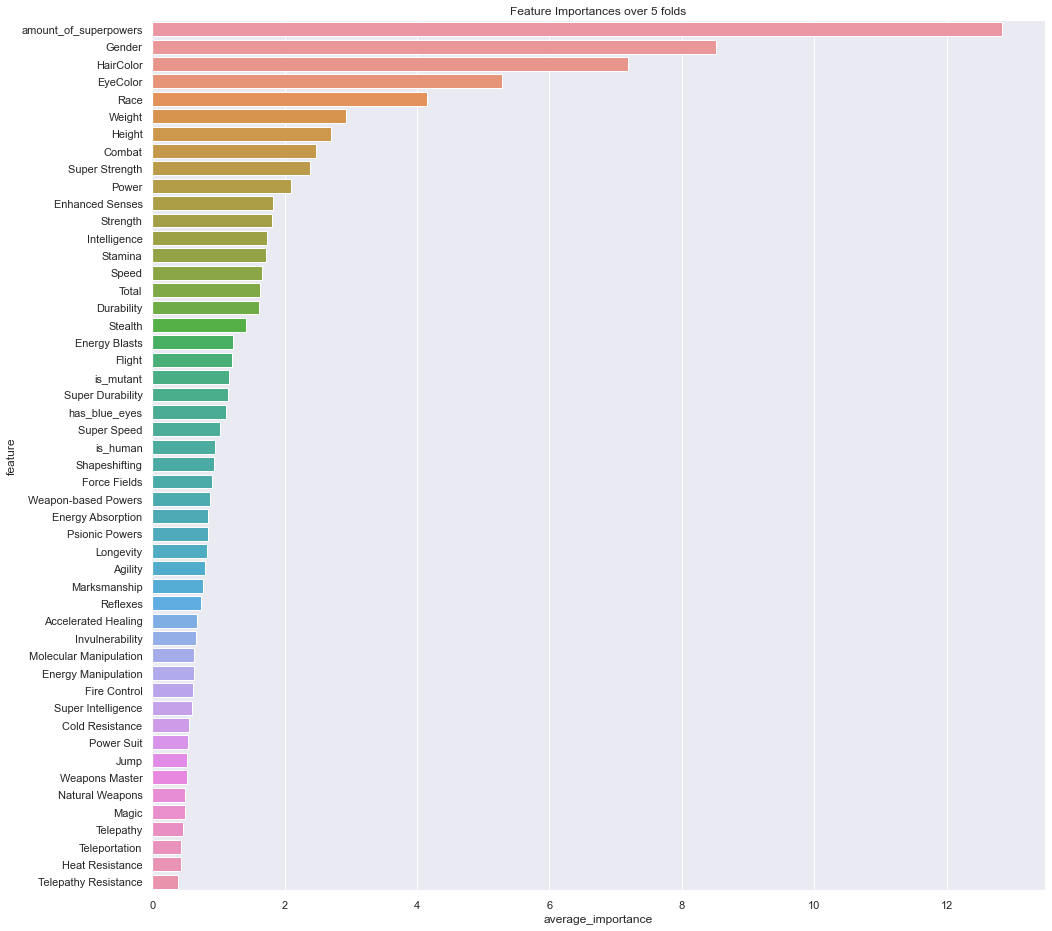

Cool to see our engineered feature 'amount_of_superpowers' is at the top. 
Also, interestingly enough, all of our categorical features are at the top as well.


In [17]:
print("Interesting results, this is a definite improvement over a 'lucky' guess. \n"
      "Lets check the feature importance as well:")
evaluation.plot_feature_importance(feature_importance, n_features_to_show=50)
print("Cool to see our engineered feature 'amount_of_superpowers' is at the top. \n"
      "Also, interestingly enough, all of our categorical features are at the top as well.")

Since we know our end goal is to create a character creator, I'd prefer to get rid of all features that don't help the model too much if any at all. 
The main reason for that is to make the layout of the UI + the process itself as clean and simple as possible, without harming the performance.


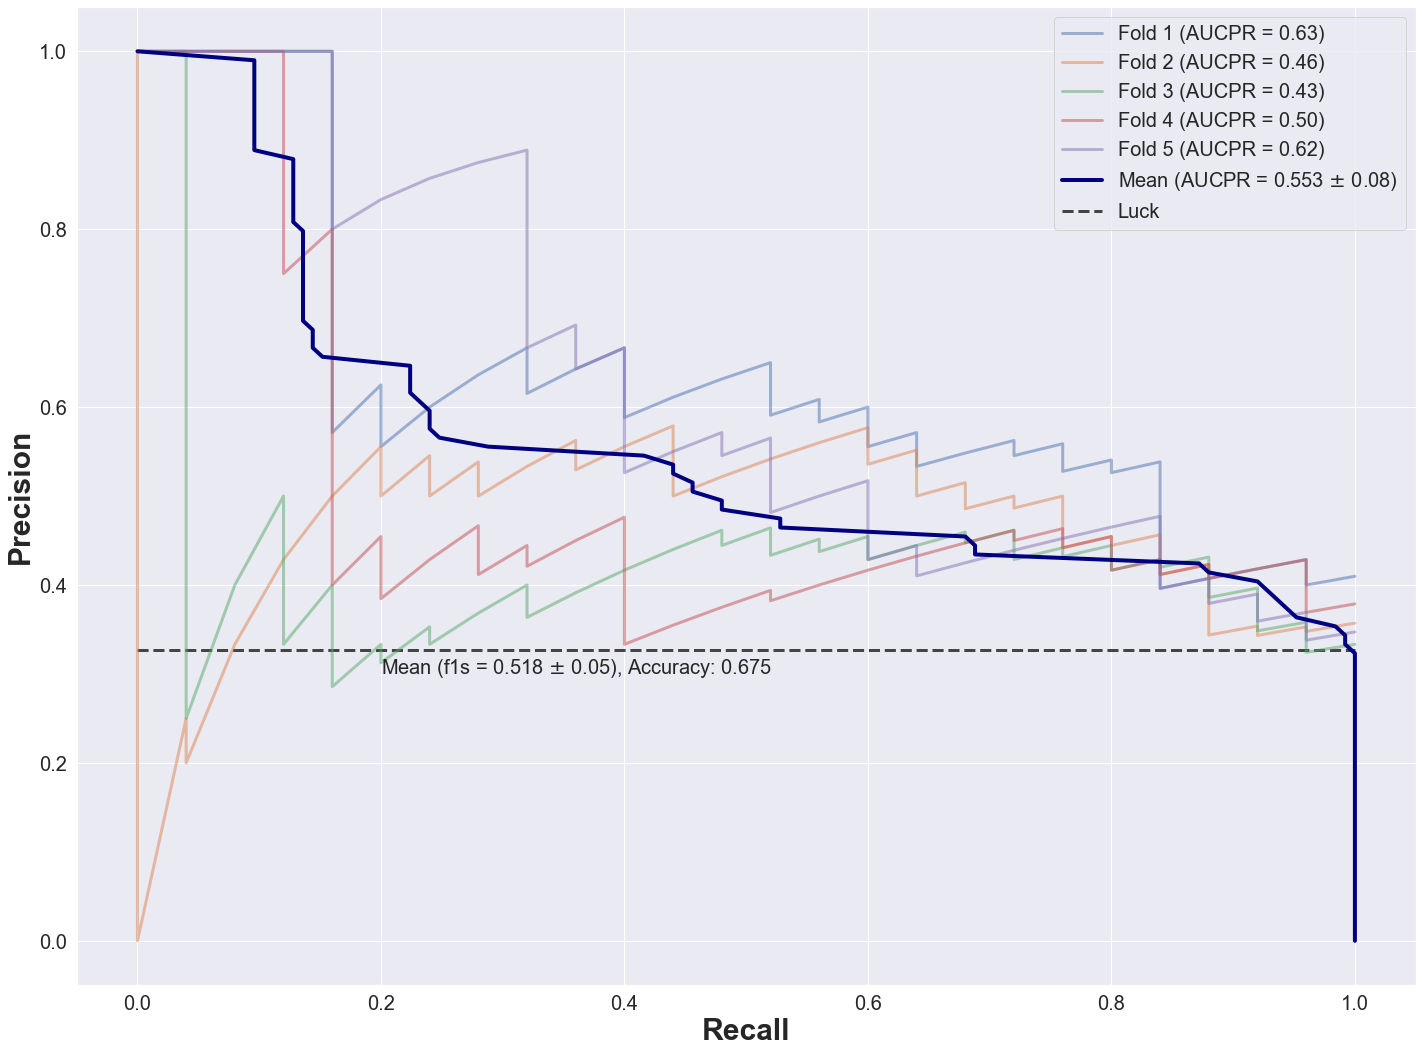

In [24]:
print("Since we know our end goal is to create a character creator, I'd prefer to get rid of all features that don't help the model too much if any at all. \n"
      "The main reason for that is to make the layout of the UI + the process itself as clean and simple as possible, without harming the performance.")
top_features_and_class = [
        # categorical features
        'Gender',
        'HairColor',
        'EyeColor',
        'Race',
        # int features
        'Strength',
        'Speed',
        'Durability',
        'Power',
        'Combat',
        'Intelligence',
        'Height',
        'Weight',
        'Total',
        'amount_of_superpowers',
        # Boolean features
        'Super Strength',
        'Stamina',
        'Stealth',
        'Enhanced Senses',
        'Flight',
        'Energy Blasts',
        'Energy Absorption',
        'Shapeshifting',
        'Accelerated Healing',
        'Force Fields',
        'Psionic Powers',
        'Weapon-based Powers',
        'Energy Manipulation',
        'Reflexes',
        'Molecular Manipulation',
        'Super Durability',
        'Agility',
        'Longevity',
        'Super Speed',
        'is_human',
        'is_mutant',
        'has_blue_eyes',
        'class']
df = df.loc[:, top_features_and_class]
X, y = df.drop('class', axis=1), df['class']
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), class_weights=[0.33, 0.67], random_state=5,
                         bootstrap_type='Bayesian', rsm=0.1, verbose=0)
feature_importance = evaluation.plot_cv_precision_recall(cbc, n_folds=5, n_repeats=1, X=X, y=y, random_state=0)

We even acheived somewhat higher accuracy. now lets explore the feature importance now:


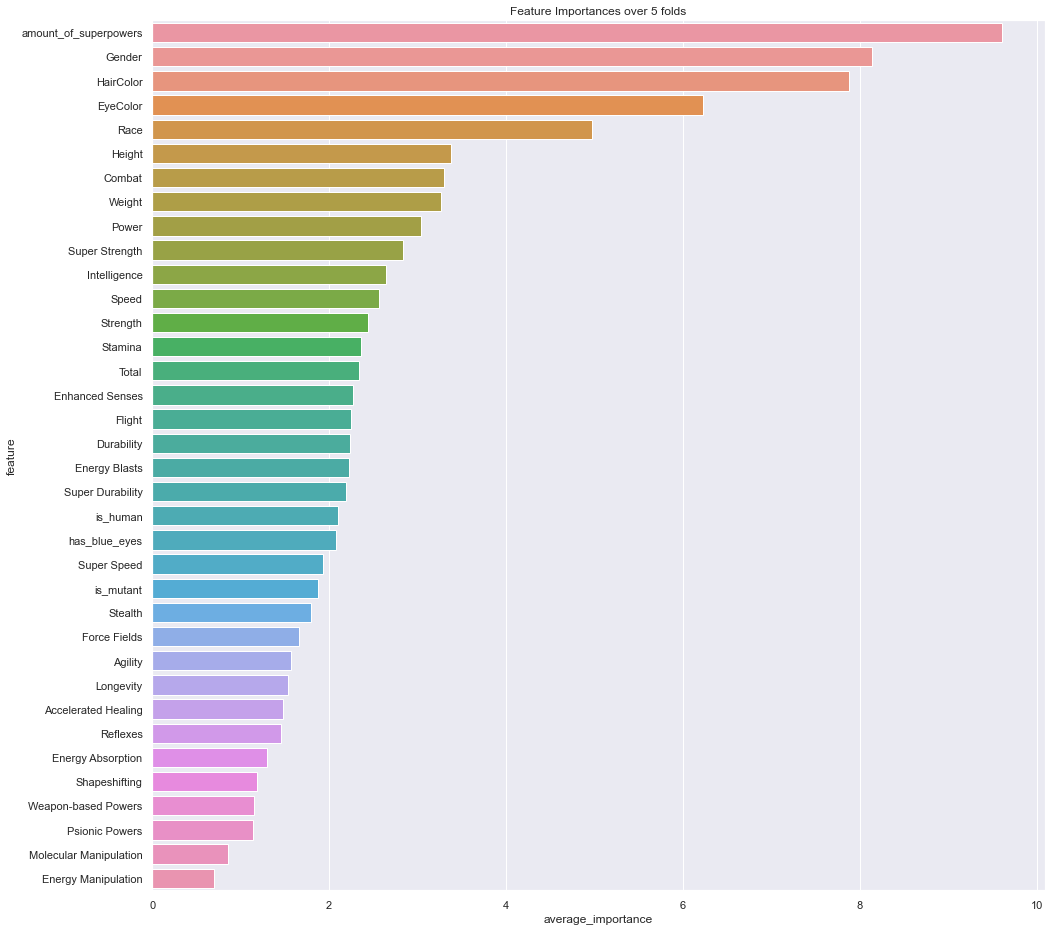

In [25]:
print("We even achieved somewhat higher accuracy. now lets explore the feature importance now:")
evaluation.plot_feature_importance(feature_importance, n_features_to_show=50)

In [ ]:
print("For further performance exploring and feature engineering, I've used the following helpful explainerdashboard package:")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
cbc.fit(X_train, y_train)
explainer = ClassifierExplainer(cbc, X_test, y_test)
ExplainerDashboard(explainer, simple=True).run()

